In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import tensorflow_hub as hub
#import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.0.0
Eager mode:  True
Hub version:  0.6.0
GPU is NOT AVAILABLE


Load train and test IMDb data as a pandas `DataFrame`. This contains 3 columns:
* sentence (`str`)
* sentiment (`int`) = number of stars
* polarity (`int`) = 0 for negative and 1 for positive reviews.

In [2]:
import data
train_data, test_data = data.load_datasets_locally("/home/stavros/DATA/IMDb")
print(train_data.columns)

Index(['sentence', 'sentiment', 'polarity'], dtype='object')


## Classification using pre-trained embeddings and PCA

Load Swivel embedder from TensorFlow Hub

In [10]:
gnews_embedder = hub.load("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1")

Try embedding IMDb data

In [51]:
n_data = 10000
example_data = train_data[:n_data]
print(np.unique(example_data["polarity"], return_counts=True))

(array([0, 1]), array([4934, 5066]))


In [52]:
embeddings = gnews_embedder(example_data["sentence"]).numpy()
print(embeddings.shape)

Use PCA to reduce embeddings from 20 to 2 dimensions in order to plot

In [53]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=10)
compressed_embeddings = pca.fit_transform(embeddings)
print("PCA Explained Variance:")
print(pca.explained_variance_)

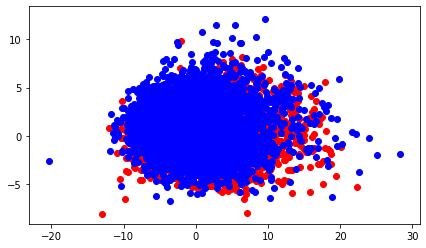

In [55]:
plt.figure(figsize=(7, 4))
ind = np.where(example_data["polarity"] == 0)[0]
plt.scatter(compressed_embeddings[ind, 0], compressed_embeddings[ind, 1], color="red")
ind = np.where(example_data["polarity"] == 1)[0]
plt.scatter(compressed_embeddings[ind, 0], compressed_embeddings[ind, 1], color="blue")
plt.show()

we see how this simple idea completely fails to classify sentiment as expected (perhaps try t-SNE instead of PCA?)

## Sentiment classification using FFNN

In [60]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", output_shape=[20],
                           input_shape=[], dtype=tf.string)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 20)                400020    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                336       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 353
Non-trainable params: 400,020
_________________________________________________________________


In [61]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

In [62]:
n_valid = 2000
model.fit(x=train_data["sentence"], y=train_data["polarity"], epochs=30, batch_size=50,
          validation_data=(test_data["sentence"][:n_valid], test_data["polarity"][:n_valid]))

Train on 25000 samples, validate on 2000 samples
Epoch 1/30
25000/25000 [==============================] - 5s 203us/sample - loss: 0.7005 - acc: 0.6099 - val_loss: 0.6047 - val_acc: 0.6775
Epoch 2/30
25000/25000 [==============================] - 5s 194us/sample - loss: 0.5802 - acc: 0.6964 - val_loss: 0.5718 - val_acc: 0.7090
Epoch 3/30
25000/25000 [==============================] - 5s 198us/sample - loss: 0.5647 - acc: 0.7118 - val_loss: 0.5644 - val_acc: 0.7145
Epoch 4/30
25000/25000 [==============================] - 5s 204us/sample - loss: 0.5584 - acc: 0.7154 - val_loss: 0.5563 - val_acc: 0.7230
Epoch 5/30
25000/25000 [==============================] - 5s 202us/sample - loss: 0.5537 - acc: 0.7195 - val_loss: 0.5486 - val_acc: 0.7195
Epoch 6/30
25000/25000 [==============================] - 5s 211us/sample - loss: 0.5508 - acc: 0.7194 - val_loss: 0.5501 - val_acc: 0.7200
Epoch 7/30
25000/25000 [==============================] - 8s 316us/sample - loss: 0.5497 - acc: 0.7220 - val_lo

KeyboardInterrupt: 